In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
import datetime 
import networkx as nx
from sklearn.decomposition import PCA

In [3]:
file = r'C:\Users\Melis\Downloads\soc-sign-bitcoinotc.csv.gz'

df = pd.read_csv(file, compression='gzip', header=None, names=['Source', 'Target', 'Rating', 'Time'])
print(df)

       Source  Target  Rating          Time
0           6       2       4  1.289242e+09
1           6       5       2  1.289242e+09
2           1      15       1  1.289243e+09
3           4       3       7  1.289245e+09
4          13      16       8  1.289254e+09
...       ...     ...     ...           ...
35587    4499    1810       1  1.453612e+09
35588    2731    3901       5  1.453679e+09
35589    2731    4897       5  1.453679e+09
35590      13    1128       1  1.453680e+09
35591    1128      13       2  1.453684e+09

[35592 rows x 4 columns]


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35592 entries, 0 to 35591
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Source  35592 non-null  int64  
 1   Target  35592 non-null  int64  
 2   Rating  35592 non-null  int64  
 3   Time    35592 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 1.1 MB


In [7]:
df['Datetime'] = pd.to_datetime(df['Time'], unit='s')
print(df)

       Source  Target  Rating          Time                      Datetime
0           6       2       4  1.289242e+09 2010-11-08 18:45:11.728359936
1           6       5       2  1.289242e+09 2010-11-08 18:45:41.533780224
2           1      15       1  1.289243e+09 2010-11-08 19:05:40.390490112
3           4       3       7  1.289245e+09 2010-11-08 19:41:17.369750016
4          13      16       8  1.289254e+09 2010-11-08 22:10:54.447459840
...       ...     ...     ...           ...                           ...
35587    4499    1810       1  1.453612e+09 2016-01-24 05:14:41.647290112
35588    2731    3901       5  1.453679e+09 2016-01-24 23:50:28.049489920
35589    2731    4897       5  1.453679e+09 2016-01-24 23:50:34.034019840
35590      13    1128       1  1.453680e+09 2016-01-24 23:53:52.985709824
35591    1128      13       2  1.453684e+09 2016-01-25 01:12:03.757280000

[35592 rows x 5 columns]


In [9]:
#Creating directed graph of the data
G = nx.DiGraph()
for _, row in df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Rating'])

In [10]:
#Extracting sturctural signatures (k-hop Degree Sequences)
#for each node, computing the degree sequence of k-hop neighborhoods
def degree_signature(graph, node, k=3, max_len=10):
    signature = []
    for dist in range(1, k+1):
        neighbors = [n for n, d in nx.single_source_shortest_path_length(graph, node, cutoff=dist).items() if d == dist]
        degrees = sorted([graph.degree(n) for n in neighbors])
        # Pad or truncate to ensure fixed length
        padded = degrees[:max_len] + [0] * max(0, max_len - len(degrees))
        signature.extend(padded)
    return signature

nodes = list(G.nodes())
signature_matrix = np.array([degree_signature(G, node, k=3) for node in nodes])

In [11]:
#Computing similarity martix
def cosine_similarity_matrix(X):
    X_norm = X / (norm(X, axis=1, keepdims=True) + 1e-10)
    return np.dot(X_norm, X_norm.T)

similarity_matrix = cosine_similarity_matrix(signature_matrix)
distance_matrix = 1 - similarity_matrix

In [12]:
#Reducing to low dimensional embeddings
pca = PCA(n_components=8)  # Embedding dimension
embedding = pca.fit_transform(distance_matrix)

In [14]:
#Creating final embedding table
embedding_df = pd.DataFrame(embedding, index=nodes)
embedding_df.columns = [f'embed_{i}' for i in range(embedding.shape[1])]

# Combine with node ID if needed
embedding_df['node'] = embedding_df.index
embedding_df.reset_index(drop=True, inplace=True)

In [14]:
print(embedding_df)

        embed_0    embed_1    embed_2   embed_3   embed_4   embed_5   embed_6  \
0    -12.163336  -4.730608  18.342917 -1.128626 -0.276001  0.465466 -0.223412   
1    -14.000478  -6.606561  17.380634 -0.005585  0.230445  0.209341  0.228105   
2     -3.193682  18.427377   3.146853  4.753032 -0.779693 -5.010256 -1.289956   
3     -7.036759   1.037637  16.036885 -0.037855  6.078234  1.094369 -0.489755   
4    -13.715483  -7.237398  14.689700 -3.404587 -1.111445 -2.350577  2.575875   
...         ...        ...        ...       ...       ...       ...       ...   
5876  24.846557  -4.897955   0.938919  1.542570 -3.373844 -0.193129  0.022677   
5877  -8.751647  -3.841525 -11.198687 -1.098966 -2.544046 -0.644281  0.190609   
5878  -8.751647  -3.841525 -11.198687 -1.098966 -2.544046 -0.644281  0.190609   
5879  -8.751647  -3.841525 -11.198687 -1.098966 -2.544046 -0.644281  0.190609   
5880  -8.751647  -3.841525 -11.198687 -1.098966 -2.544046 -0.644281  0.190609   

       embed_7  node  
0   

In [15]:
embedding_df.to_csv('struc2vec-embeddings.csv')

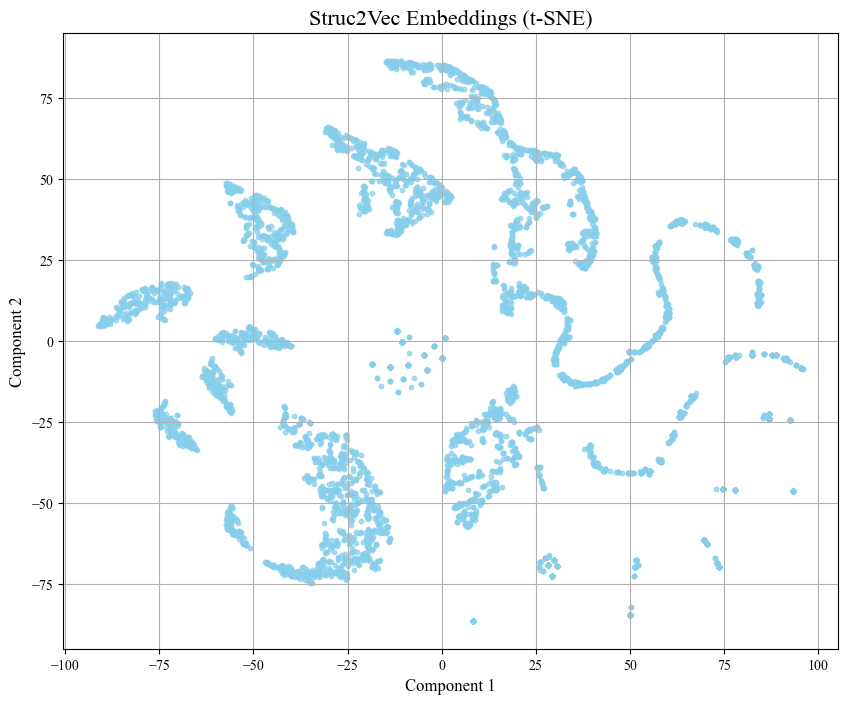

In [21]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Set Times New Roman as default font
plt.rcParams["font.family"] = "Times New Roman"

# Example: Project high-dimensional embeddings to 2D
tsne = TSNE(n_components=2, random_state=42)
embedding_2d = tsne.fit_transform(embedding)  # assuming `embedding` exists

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=10, alpha=0.7, color='skyblue')
plt.title("Struc2Vec Embeddings (t-SNE)", fontsize=16)
plt.xlabel("Component 1", fontsize=12)
plt.ylabel("Component 2", fontsize=12)
plt.grid(True)
plt.show()